In [21]:
from datetime import datetime

import talib
import pandas
import MetaTrader5 as mt5
import matplotlib.pyplot as plt

from backtesting.backtesting import Backtest
from backtesting.lib import SignalStrategy, TrailingStrategy

In [34]:
mt5.initialize()

utc_from = datetime(2020, 6, 9) 

AUDUSD = mt5.copy_rates_from('AUDUSDm', mt5.TIMEFRAME_D1, utc_from, 10000)
AUDUSD = pandas.DataFrame(AUDUSD)

AUDUSD.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'Real_Volume']
AUDUSD = AUDUSD.set_index(AUDUSD['Datetime'].apply(datetime.fromtimestamp))
AUDUSD['momentum'] = AUDUSD['Close'].pct_change(10)
bollinger = talib.BBANDS(AUDUSD['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

AUDUSD['upperband']  = bollinger[0]
AUDUSD['middleband'] = bollinger[1]
AUDUSD['lowerband']  = bollinger[2]

AUDUSD['upperband']  = AUDUSD['upperband'].shift(1)
AUDUSD['middleband'] = AUDUSD['middleband'].shift(1)
AUDUSD['lowerband']  = AUDUSD['lowerband'].shift(1)

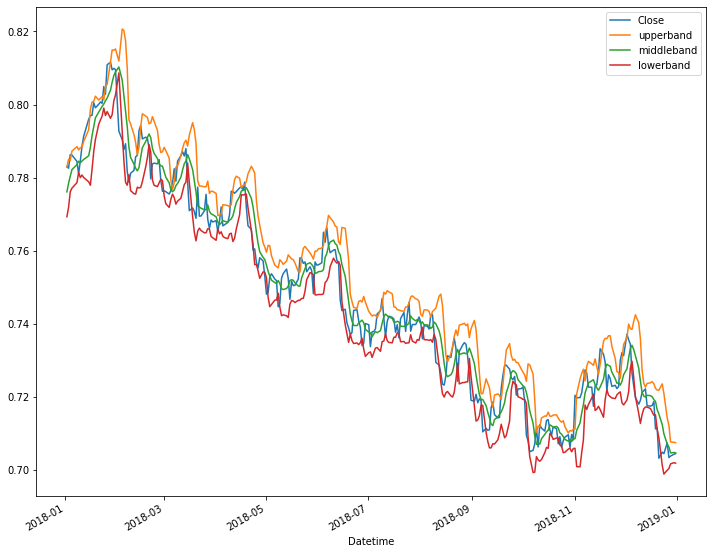

In [35]:
AUDUSD[['Close', 'upperband', 'middleband', 'lowerband']]['2018'].plot(figsize=(12, 10))

In [36]:
AUDUSD['signal_buy']       = (AUDUSD['Close'] < AUDUSD['lowerband']).astype(int)
AUDUSD['signal_close_buy'] = (AUDUSD['Close'] > AUDUSD['middleband']).astype(int)

AUDUSD['signal_sell']       = (AUDUSD['Close'] > AUDUSD['upperband']).astype(int)
AUDUSD['signal_close_sell'] = (AUDUSD['Close'] < AUDUSD['middleband']).astype(int)

AUDUSD['signal_long']  = 0
AUDUSD['signal_short'] = 0 

In [37]:
position_long = False
for index, row in AUDUSD.iterrows():
    
    if position_long and row['signal_close_buy']:
        AUDUSD.loc[index, 'signal_long'] = 0
        position_long = False
        continue
    
    if not position_long and row['signal_buy']:
        AUDUSD.loc[index, 'signal_long'] = 1
        position_long = True
        continue
    
    if position_long:
        AUDUSD.loc[index, 'signal_long'] = 1

In [38]:
position_short = False
for index, row in AUDUSD.iterrows():
    
    if position_short and row['signal_close_sell']:
        AUDUSD.loc[index, 'signal_short'] = 0
        position_short = False
        continue
    
    if not position_short and row['signal_sell']:
        AUDUSD.loc[index, 'signal_short'] = -1
        position_short = True
        continue
    
    if position_short:
        AUDUSD.loc[index, 'signal_short'] = -1

In [39]:
AUDUSD['signal'] = AUDUSD['signal_long'] + AUDUSD['signal_short']

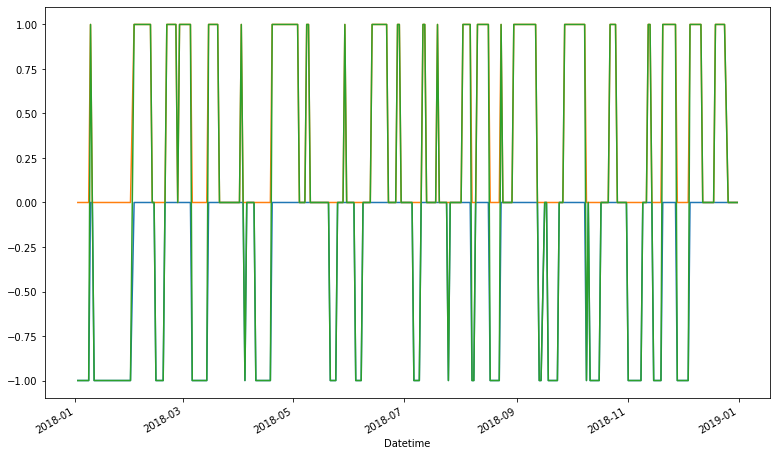

In [40]:
AUDUSD['2018']['signal_short'].plot(figsize=(13, 8))
AUDUSD['2018']['signal_long'].plot()
AUDUSD['2018']['signal'].plot()

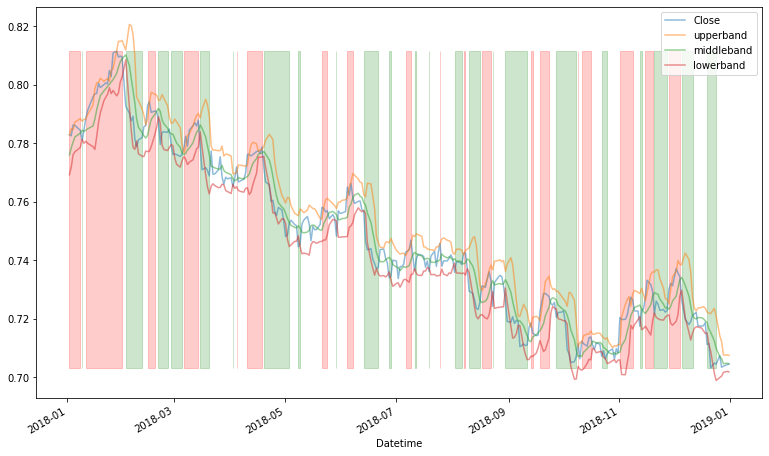

In [41]:
AUDUSD[['Close', 'upperband', 'middleband', 'lowerband']]['2018'].plot(figsize=(13, 8), alpha=0.5)
plt.fill_between(AUDUSD['2018'].index, AUDUSD['2018']['Close'].min(), AUDUSD['2018']['Close'].max(), where=AUDUSD['2018']['signal'] > 0, color='g', alpha=0.2)
plt.fill_between(AUDUSD['2018'].index, AUDUSD['2018']['Close'].min(), AUDUSD['2018']['Close'].max(), where=AUDUSD['2018']['signal'] < 0, color='r', alpha=0.2)

In [52]:
class MeanReverseBBAND(SignalStrategy, TrailingStrategy):
    n1 = 10
    n2 = 25
    
    def init(self):
        super().init()
        
        signal = self.data.signal
        
        entry_size = signal * .95

        self.set_signal(entry_size=entry_size)

In [53]:
bt = Backtest(AUDUSD, MeanReverseBBAND)

bt.run()
bt.plot()

C:\Users\tempurak\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  after removing the cwd from sys.path.
